In [84]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

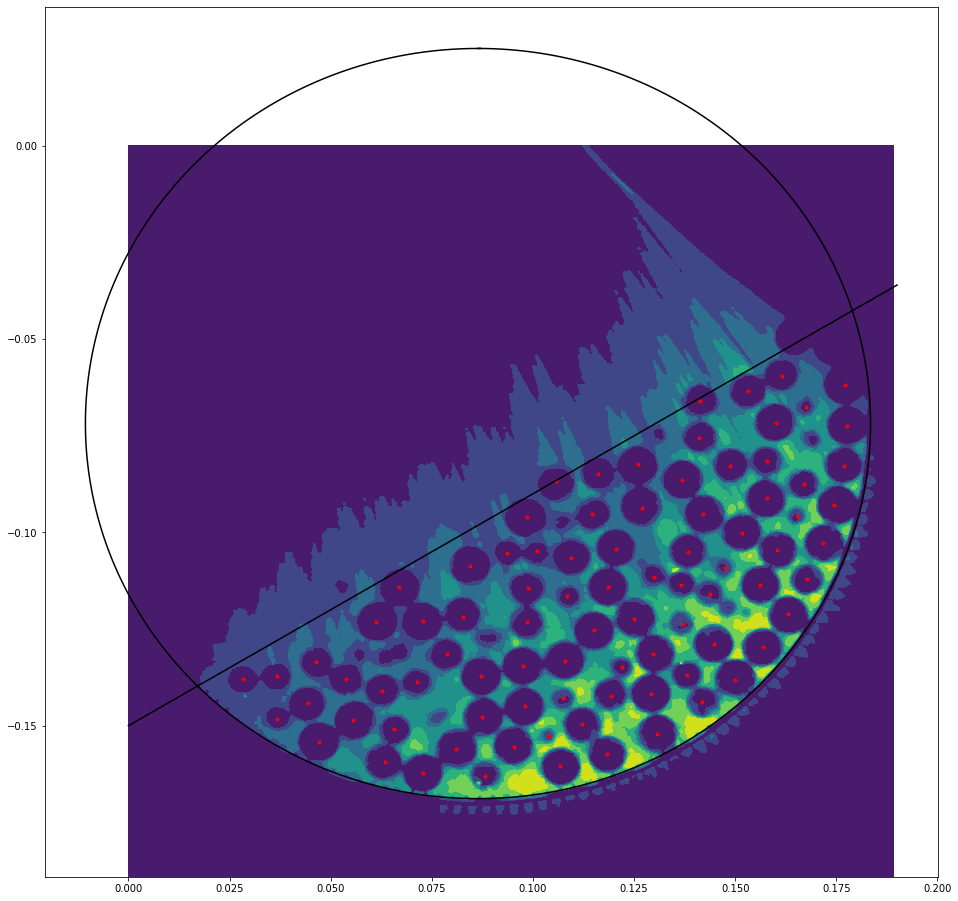

In [85]:
file_location = '/home/bay22/git_repositories/RIMSAR/'

background_image = cv2.imread(file_location + 'notebooks/01_exploration/RIMS_analysis/Os4-S3 Camera000000.tif',0).astype(np.float64)
#x and z coordinates:

xbi, zbi = np.meshgrid(np.arange(0.0,1024,1),np.arange(0.0,1024,1))

#importing point data:

point_data = np.loadtxt(file_location + 'data/02_intermediate/point_data/point_data_0.dat')
#print(point_data)

pixel2real = 0.0001848337

Xu = point_data[:,0]*pixel2real
Zu = -point_data[:,1]*pixel2real

xbi *= pixel2real
zbi *= -pixel2real


dt = 0.01
xc = 467.5*pixel2real
zc = -388.6*pixel2real
#r = 524.8*pixel2real #true radius
#r = 480*pixel2real
R = 525*pixel2real

#R = 400*pixel2real
theta = np.arange(0,2*3.14159+dt,dt)
xcircle = xc + R*np.sin(theta)
zcircle = zc + R*np.cos(theta)
xline = np.arange(0,0.2,0.01)
m = 0.6
#c = -0.155
c= -0.15

#c = -0.17
yline = xline*m + c


plt.figure(figsize=(16,16))
plt.contourf(xbi,zbi,background_image)
plt.plot(Xu,Zu,'.',color = 'r')
plt.plot(xcircle,zcircle,'k')
plt.plot(xline,yline,'k')
#boundary geometry

In [86]:
dx = 5.0
xbi, zbi = np.meshgrid(np.arange(0.0,1024,dx),np.arange(0.0,1024,dx))

xbi *= pixel2real
zbi *= -pixel2real
cr = 0.06
file_name = '0_06'
rho_orig = xbi*0


#coarse graining with renormalized Lucy function:
Nparticles = point_data.shape[0]
rho = xbi*0

epsilon = 1e-5

mean_rho = xbi*0
mean_u = xbi*0
mean_v = xbi*0

savealltimesteps = False

if savealltimesteps:

    for j in range(0,5000):

        rho = xbi*0
        momentumx = xbi*0
        momentumz = xbi*0
        point_data = np.loadtxt(file_location + 'data/02_intermediate/point_data/point_data_'+str(j)+'.dat')
        #point_data = np.loadtxt('point_data/point_data_'+str(j)+'.dat')
        Xu = point_data[:,0]*pixel2real
        Zu = -point_data[:,1]*pixel2real
        Nparticles = point_data.shape[0]



        for i in range(0,Nparticles):

            #check if particle is in zone:
            if Xu[i]*m + c >= Zu[i]:
                if (Xu[i]-xc)**2 + (Zu[i]-zc)**2 <= R**2:
                    r = np.sqrt( (xbi-Xu[i])**2 + (zbi-Zu[i])**2 )
                    r[r>cr] = cr
                    r[xbi*m+c<=zbi] = cr
                    r[(xbi-xc)**2 + (zbi-zc)**2 >= R**2] = cr
                    density = -3*(r/cr)**4 + 8*(r/cr)**3 -6*(r/cr)**2 + 1

                    #renormalizing:
                    density_integral = np.sum(np.sum(density))*(5*pixel2real)**2
                    density /= density_integral

                    #momentum 
                    particle_momentumx = point_data[i,3]*density
                    particle_momentumz = point_data[i,4]*density



                    rho += density
                    momentumx += particle_momentumx
                    momentumz += particle_momentumz
                    

        rho += epsilon
        mean_rho += rho 
        mean_u += momentumx/rho 
        mean_v += momentumz/rho
        np.savetxt('RCG_c0_025/rho'+str(j)+'.dat',rho)
        np.savetxt('RCG_c0_025/momentumx'+str(j)+'.dat',momentumx)
        np.savetxt('RCG_c0_025/momentumz'+str(j)+'.dat',momentumz)
        #print(j)

else:

    for j in range(0,5000):

        rho = xbi*0
        momentumx = xbi*0
        momentumz = xbi*0

        #point_data = np.loadtxt('point_data/point_data_'+str(j)+'.dat')
        point_data = np.loadtxt(file_location + 'data/02_intermediate/point_data/point_data_'+str(j)+'.dat')
        Xu = point_data[:,0]*pixel2real
        Zu = -point_data[:,1]*pixel2real
        Nparticles = point_data.shape[0]



        for i in range(0,Nparticles):

            #check if particle is in zone:
            if Xu[i]*m + c >= Zu[i]:
            #if True:
                if (Xu[i]-xc)**2 + (Zu[i]-zc)**2 <= R**2:
                #if True:
                    r = np.sqrt( (xbi-Xu[i])**2 + (zbi-Zu[i])**2 )
                    r[r>cr] = cr
                    r[xbi*m+c<=zbi] = cr
                    r[(xbi-xc)**2 + (zbi-zc)**2 >= R**2] = cr
                    density = -3*(r/cr)**4 + 8*(r/cr)**3 -6*(r/cr)**2 + 1

                    #renormalizing:
                    density_integral = np.sum(np.sum(density))*(5*pixel2real)**2
                    density /= density_integral

                    #momentum 
                    particle_momentumx = point_data[i,3]*density
                    particle_momentumz = point_data[i,4]*density



                    rho += density
                    momentumx += particle_momentumx
                    momentumz += particle_momentumz
                    

        rho += epsilon
        mean_rho += rho 
        mean_u += momentumx/rho 
        mean_v += momentumz/rho

    #point_data = np.loadtxt(file_location + 'data/02_intermediate/point_data/point_data_'+str(j)+'.dat')
    
    #np.savetxt('RCG_c0_2mean_rho.dat',mean_rho)
    #np.savetxt('RCG_c0_2mean_u.dat',mean_u)
    #np.savetxt('RCG_c0_2mean_v.dat',mean_v)


In [87]:
frame_rate = 300 #frames per second
mean_u *= frame_rate*pixel2real/5000
mean_v *= frame_rate*pixel2real/5000

In [88]:
#creating corase_grain file:



cg_data = np.stack((xbi.flatten(),zbi.flatten(),mean_rho.flatten(),mean_u.flatten(),mean_v.flatten()),axis=1)
#np.savetxt(file_location + 'data/03_processed/renormalized_coarse_grain/RCG_c'+file_name+'mean_rho.dat',mean_rho)
#np.savetxt(file_location + 'data/03_processed/renormalized_coarse_grain/RCG_c'+file_name+'mean_u.dat',mean_u)
#np.savetxt(file_location + 'data/03_processed/renormalized_coarse_grain/RCG_c'+file_name+'mean_v.dat',mean_v)
np.savetxt(file_location + 'data/03_processed/renormalized_coarse_grain/RCG_c'+file_name+'.dat',cg_data)

In [89]:
Nparticles 

85

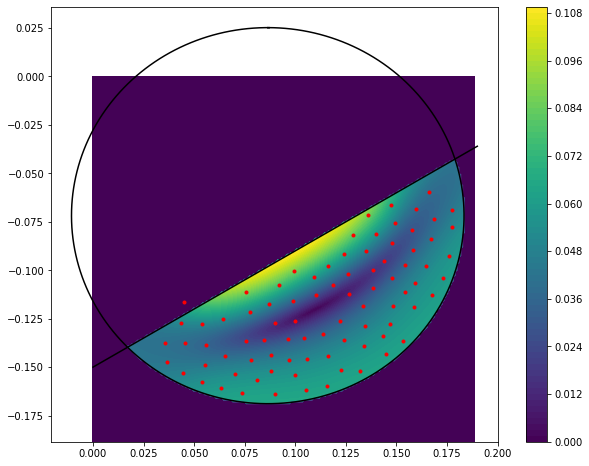

In [90]:
plt.figure(figsize=(10,8))



plt.contourf(xbi,zbi,np.sqrt(mean_u**2 + mean_v**2),levels=100)
#plt.contourf(xbi,zbi,mean_rho,levels=100)
plt.plot(Xu,Zu,'.',color = 'r')
plt.plot(xline,yline,'k')
plt.plot(xcircle,zcircle,'k')
plt.colorbar()